In [38]:
import numpy as np
import scipy.sparse.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

In [39]:
class Heisenberg:
    def __init__(self,L,nup,periodic=False,j=1.):
        self.L   = L
        self.nup = nup
        self.periodic = periodic
        self.j = j
        self.index  = -np.ones((1<<self.L),dtype=int)
        states = []
        ## find all basis states with given nup
        i = 0
        for s in range((1<<nup)-1,len(self.index)):
            if bin(s).count('1')==self.nup:
                self.index[s] = i
                states.append(s)
                i+=1
        self.states = np.array(states,dtype=int)
        self.N = len(self.states)
    def multiply(self,x):
        assert(len(x)>=self.N)
        y = np.zeros_like(x)
        # diagonal part
        for i,s in enumerate(self.states):
            jtotal = 0.
            for r in range(self.L-1):
                jtotal += -1 if ((s >> r)^(s >> (r+1)))&1 else 1
            y[i] = 0.25*self.j*jtotal*x[i]
        # off-diagonal part
        for i,s in enumerate(self.states):
            for r in range(self.L-1):
                if ((s >> r)^(s >> (r+1)))&1 :
                    sflipped = s^(3 << r)
                    y[self.index[sflipped]] += 0.5*self.j*x[i]
        if self.periodic:
            for i,s in enumerate(self.states):
                y[i] += 0.25*self.j*(-1 if (s^(s >> (self.L-1)))&1 else 1)*x[i]
                if (s^(s >> (self.L-1)))&1 :
                    sflipped = s^(1|(1 << (self.L-1)))
                    y[self.index[sflipped]] += 0.5*self.j*x[i]
        return y   

# Test Energies

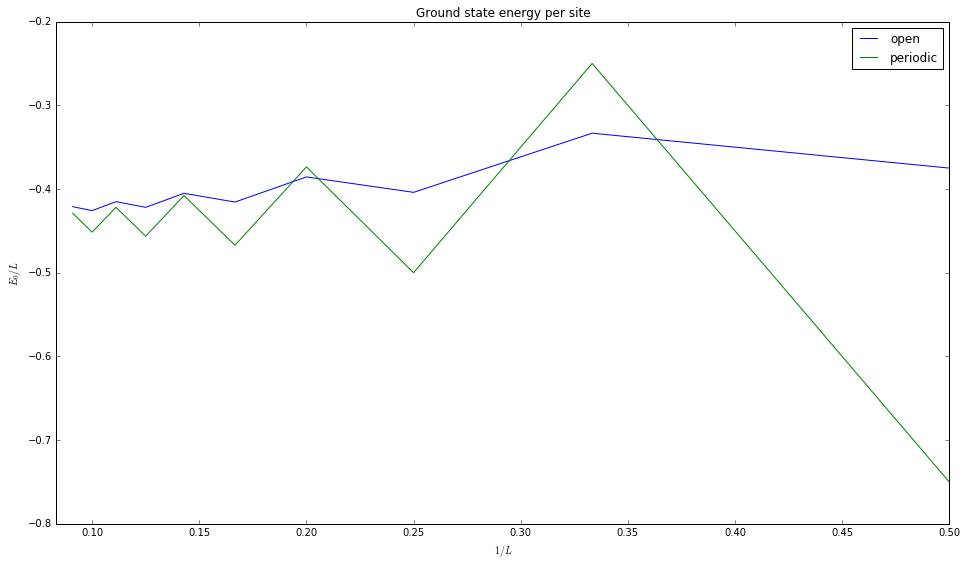

In [44]:
E_o = []
E_p = []
Lmin = 2
Lmax = 12
for L in range(Lmin,Lmax):
    nup = L//2
    heis_o = Heisenberg(L,nup,periodic=False)
    H = LA.LinearOperator( (heis_o.N,heis_o.N), matvec=heis_o.multiply)
    w,_ = LA.eigsh(H, 1, which='SA')
    E_o.append(w/L)
    heis_p = Heisenberg(L,nup,periodic=True)
    H = LA.LinearOperator( (heis_p.N,heis_p.N), matvec=heis_p.multiply)
    w,_ = LA.eigsh(H, 1, which='SA')
    E_p.append(w/L)

plt.figure()
plt.plot(1/np.arange(Lmin,Lmax),E_o,label='open')
plt.plot(1/np.arange(Lmin,Lmax),E_p,label='periodic')
plt.xlim([1/Lmax,1/Lmin])
plt.title('Ground state energy per site')
plt.xlabel('$1/L$')
plt.ylabel('$E_0/L$')
plt.legend()
plt.show()